In [3]:
# Imports neccesary to work on the project
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import random

In [4]:
# We begin the process of unifying the images in their corresponding category.
cat_train_images = glob.glob('./PetImages/Cat/*.jpg')
dog_train_images = glob.glob('./PetImages/Dog/*.jpg')

cat_test_images = glob.glob('./PetImages/Cat/*.jpg')
dog_test_images = glob.glob('./PetImages/Dog/*.jpg')

In [5]:
print(f"Number of CAT images: {len(cat_train_images)}")
print(f"Number of DOG images: {len(dog_train_images)}")

Number of CAT images: 12498
Number of DOG images: 12498


In [6]:
# Labels are assigned to the images, e.g. 0 for CAT and 1 for DOG.
cat_train_labels = [0] * len(cat_train_images)
dog_train_labels = [1] * len(dog_train_images)

cat_test_labels = [0] * len(cat_test_images)
dog_test_labels = [1] * len(dog_test_images)

In [7]:
# The images and labels from the CAT and DOG folders are now combined into a single dataset.
train_images = cat_train_images + dog_train_images
train_labels = cat_train_labels + dog_train_labels

test_images = cat_test_images + dog_test_images
test_labels = cat_test_labels + dog_test_labels

In [8]:
# The data set is shuffled to ensure a good distribution of the images.
train_indices = np.arange(len(train_images))
np.random.shuffle(train_indices)
train_images = [train_images[i] for i in train_indices]
train_labels = [train_labels[i] for i in train_indices]

test_indices = np.arange(len(test_images))
np.random.shuffle(test_indices)
test_images = [test_images[i] for i in test_indices]
test_labels = [test_labels[i] for i in test_indices]

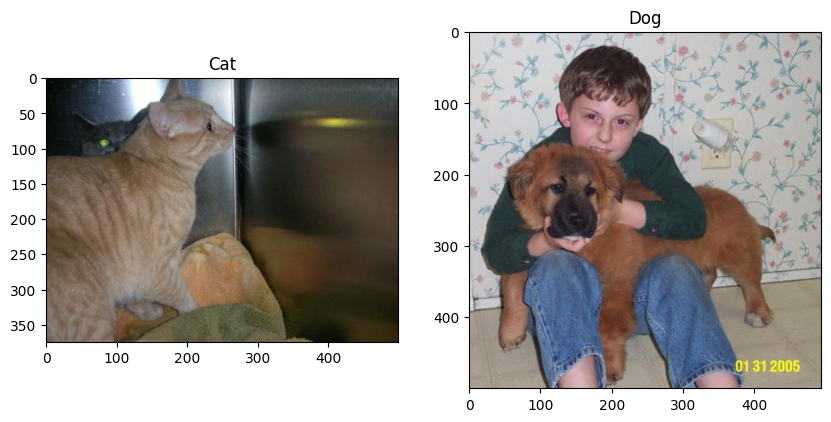

In [9]:
# Both cases are shown in order to observe the differences clearly
train_cat = './PetImages/Cat/'
train_dog = './PetImages/Dog/'

# Cat pic
rand_cat = np.random.randint(0, len(os.listdir(train_cat)))
cat_pic = os.listdir(train_cat)[rand_cat]
cat_pic_address = train_cat + cat_pic

# Dog pic
rand_dog = np.random.randint(0, len(os.listdir(train_dog)))
dog_pic = os.listdir(train_dog)[rand_dog]
dog_address = train_dog + dog_pic

# Load the images and convert to grayscale
cat_load = Image.open(cat_pic_address)
dog_load = Image.open(dog_address)

# Plot the images
f = plt.figure(figsize=(10, 6))
a1 = f.add_subplot(1, 2, 1)
img_plot = plt.imshow(cat_load)
a1.set_title('Cat')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(dog_load)
a2.set_title('Dog')

plt.show()

In [10]:
# Data is loaded and formatted to make sure it fits the CNN
def random_rotation_angle():
    return random.randint(0, 360)

def load_images(path, label):
    images = []
    labels = []
    for img_path in glob.glob(path + '/*.jpg'):
        img = Image.open(img_path).convert('L').resize((150, 150))
        rotation_angle = random_rotation_angle()
        rotated_img = img.rotate(rotation_angle)
        img_array = np.array(rotated_img) / 255.0
        images.append(img_array)
        labels.append(label)
    return images, labels

train_cat = './PetImages/Cat/'
train_dog = './PetImages/Dog/'

cat_images, cat_labels = load_images(train_cat, 0)
dog_images, dog_labels = load_images(train_dog, 1)

images = cat_images + dog_images
labels = cat_labels + dog_labels

images = np.array(images)
labels = np.array(labels)
images = images.reshape(-1, 150, 150, 1)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

/usr/lib64/python3.11/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [11]:
# CNN is developed for this problem in particular
model = tf.keras.models.Sequential()

# First layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1), padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25)) # Add dropout layer

# Second layer
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25)) # Add dropout layer

# Third layer
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25)) # Add dropout layer

# Fourth layer
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25)) # Add dropout layer

# Flatten and add fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5)) # Add dropout layer
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5)) # Add dropout layer
model.add(layers.Dense(2, activation='softmax'))

model.summary()

2023-05-14 01:45:03.463259: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-14 01:45:03.465090: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 64)          0

In [14]:
# This callback function serves to end training if desired accuracy is reached

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.98):
      print("\nReached 98% accuracy so cancelling training!")
      self.model.stop_training = True


In [15]:
# We import the callback class to instantiate the callback function
callbacks = myCallback()

# The model is compiled in order to start training
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
              )
# The data is fitted to the model and training starts
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[callbacks])

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/unclepete/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_5557/2545235475.py", line 10, in <module>
    history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callback=[callbacks])
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    filtered_tb = _process_traceback_frames(e.__traceback__)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: Model.fit() got an unexpected keyword argument 'callback'

During handling of the above exception, another except